In [1]:
#import all the important libraries 
from pyspark.ml import feature
from pyspark.ml import clustering
from pyspark.ml import Pipeline
from pyspark.sql import functions as fn
import numpy as np
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import concat_ws, col, lit
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import IDF
import requests
import seaborn as sns
from scipy import stats
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
from pyspark.sql import functions as fn
from pyspark.ml.classification import GBTClassifier
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

In [3]:
#read csv fike in dataframe
data = spark.read.csv('Accidents.csv',header = True)

In [4]:
#function to drop all columns that have null values in all the rows
import pyspark.sql.functions as F
def drop_null_columns(df):
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v == data.count()]
    df = df.drop(*to_drop)
    return df

# Drops column b2, because it contains null values
drop_null_columns(data).show()


+----+--------+-----+--------+-------------------+-------------------+---------+----------+-------+-------+------------+--------------------+------+--------------------+----+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID|  Source|  TMC|Severity|         Start_Time|           End_Time|Start_Lat| Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|Number|              Street|Side|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Conditi

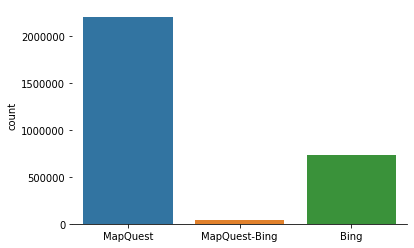

In [5]:
#count plot for source column
source = data.select("Source").collect()
source = [s.Source for s in source]
sns.countplot(x= source)
sns.despine(left = True)

As we can see most of the accidents were reported by Mapquest, and then bing 

In [ ]:
#na values in each column
from pyspark.sql.functions import isnan, when, count, col
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

In [ ]:
#drop End_lat and End_lng as they have many null values 
data = data.drop('End_Lat')
data = data.drop('End_Lng')

In [ ]:
#calculate mean for numeric columns
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
col_list = ['Distance(mi)','Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)']
df_float_mean = data.select([_mean(col(c)).alias('mean_'+str(c)) for c in col_list])

In [ ]:
# replace null values with mean
mean_Distance = df_float_mean.select('mean_Distance(mi)').collect()[0]['mean_Distance(mi)']
mean_Temperature = df_float_mean.select('mean_Temperature(F)').collect()[0]['mean_Temperature(F)']
mean_Wind_Chill = df_float_mean.select('mean_Wind_Chill(F)').collect()[0]['mean_Wind_Chill(F)']
mean_Humidity = df_float_mean.select('mean_Humidity(%)').collect()[0]['mean_Humidity(%)']
mean_Pressure = df_float_mean.select('mean_Pressure(in)').collect()[0]['mean_Pressure(in)']
mean_Visibility = df_float_mean.select('mean_Visibility(mi)').collect()[0]['mean_Visibility(mi)']
mean_Wind_Speed = df_float_mean.select('mean_Wind_Speed(mph)').collect()[0]['mean_Wind_Speed(mph)']
mean_Precipitation = df_float_mean.select('mean_Precipitation(in)').collect()[0]['mean_Precipitation(in)']

In [ ]:
data = data.fillna({'Temperature(F)':mean_Temperature,'Wind_Chill(F)':mean_Wind_Chill,'Humidity(%)':mean_Humidity,'Pressure(in)':mean_Pressure,'Visibility(mi)':mean_Visibility,'Wind_Speed(mph)':mean_Wind_Speed,'Precipitation(in)':mean_Precipitation})

In [ ]:
#na values in each column
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

In [ ]:
#drop all rows that contain null values and drop Number column as it has 2/3rd values as null
data = data.drop('Number')
data = data.na.drop(subset=["City"])
data = data.na.drop(subset=["State"])
data = data.na.drop(subset=["Zipcode"])
data = data.na.drop(subset=["Timezone"])
data = data.na.drop(subset=["Airport_code"])
data = data.na.drop(subset=["Weather_Timestamp"])
data = data.na.drop(subset=["Sunrise_Sunset"])
data = data.na.drop(subset=["Civil_Twilight"])
data = data.na.drop(subset=["Nautical_Twilight"])
data = data.na.drop(subset=["Astronomical_Twilight"])
data = data.na.drop(subset=["Wind_Direction"])
data = data.na.drop(subset=["Weather_Condition"])
data = data.na.drop(subset=["TMC"])
data = data.na.drop(subset=["Description"])

In [ ]:
#Number of acc per state
num_Acc = data.groupBy('State').count().alias("counts")

num_Acc= num_Acc.toDF('State','count_state').toPandas()

plt.figure(figsize=(25,15))
sns.set(style="white")
g= sns.barplot(x="State",y="count_state",data=num_Acc,color=(0.21569, 0.21569 ,0.21569))

g.set_xticklabels(rotation=90,labels=num_Acc['State'])
g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Number of Acidents per State",fontsize=20)
g.set_xlabel('State',fontsize=14)
sns.despine(left=True)

locs, labels = plt.xticks() # get the current tick locations and labels

for loc, label in zip(locs, labels):
    count = num_Acc.iloc[loc].count_state
    plt.text(loc, count-8, '{:0.0f}'.format(count), ha='center', va='bottom' ,color = 'black',size=11)




In [ ]:
#Top 20 Counts with max accidents 
coynty_max = data.groupBy('County').count().alias("count_county")
coynty_max= coynty_max.toDF('County','count_county').toPandas().sort_values(by = 'count_county',ascending = False)[:20]

In [ ]:
plt.figure(figsize=(25,15))
sns.set(style="white")
g= sns.barplot(x="County",y="count_county",data=coynty_max,color=(0.21569, 0.21569 ,0.21569))

g.set_xticklabels(rotation=90,labels=coynty_max['County'])
g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Countys with max num of accidents",fontsize=20)
g.set_xlabel('County',fontsize=14)
sns.despine(left=True)

In [ ]:
#Top 20 Weather_Conditions with max accidents 
conditions = data.groupBy('Weather_Condition').count().alias("count_weather")
conditions= conditions.toDF('Weather_Condition','count_weather').toPandas().sort_values(by = 'count_weather',ascending = False)[:20]
plt.figure(figsize=(25,15))
sns.set(style="white")
g= sns.barplot(x="Weather_Condition",y="count_weather",data=conditions,color=(0.21569, 0.21569 ,0.21569))

g.set_xticklabels(rotation=90,labels=conditions['Weather_Condition'])
g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Countys with max num of accidents",fontsize=20)
g.set_xlabel('Weather_Condition',fontsize=14)
sns.despine(left=True)

In [ ]:
#!pip install plotly
#graphical representation of num of accidents state wise
import plotly.graph_objects as go
state = data.select('State').collect()
state = [s.State for s in state]
df_st_ct = pd.value_counts(pd.Series(state))
fig = go.Figure(data=go.Choropleth(
    locations=df_st_ct.index,
    z = df_st_ct.values.astype(float),  # Data to be color-coded
    locationmode = 'USA-states',     # set of locations match entries in `locations`
    colorscale = 'amp',
    colorbar_title = "Count",
))

fig.update_layout(
    title_text = 'US Accidents by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [ ]:
#count plot for severity
severity_dist = data.groupBy('Severity').count().alias("count_Severity")
severity_dist= severity_dist.toDF('Severity','count_Severity').toPandas()
plt.figure(figsize=(25,15))
sns.set(style="white")
g= sns.barplot(x="Severity",y="count_Severity",data=severity_dist,color=(0.21569, 0.21569 ,0.21569))


g.set(yticklabels=[])
g.set_ylabel('')
g.axes.set_title("Number of Acidents per State",fontsize=20)
g.set_xlabel('Severity',fontsize=14)
sns.despine(left=True)


In [ ]:
#number of data points with severity =1 and 4 are very less thus replace them with 2 and 3
data = data.withColumn("Severity", F.when(F.col("Severity")=='1', 2).otherwise(F.col("Severity")))

In [ ]:
data = data.withColumn("Severity", F.when(F.col("Severity")==4, 3).otherwise(F.col("Severity")))

In [ ]:
data.filter(col("Severity")=='2').count()/data.filter(col("Severity")=='3').count()

In [ ]:
#The data is very huge so we have used just a part of it to run models. We have stratified sampling for selecting data
sampled_data = data.sampleBy("Severity", fractions={'2': 0.3, '3': 0.3}, seed=0)
sampled_data.show()

In [ ]:
#The ratio of num of col with severity =2 /severity =3 remains same even after sampling 
sampled_data.filter(col("Severity")==2).count()/sampled_data.filter(col("Severity")==3).count()

In [ ]:
#Cast distance to doubletype
from pyspark.sql.types import *
sampled_data = sampled_data.withColumn('Distance(mi)', col('Distance(mi)').cast(DoubleType())).withColumn('Temperature(F)', col('Temperature(F)').cast(DoubleType())).withColumn('Wind_Chill(F)', col('Humidity(%)').cast(DoubleType())).withColumn('Humidity(%)', col('Wind_Chill(F)').cast(DoubleType())).withColumn('Pressure(in)', col('Pressure(in)').cast(DoubleType())).withColumn('Visibility(mi)', col('Visibility(mi)').cast(DoubleType())).withColumn('Wind_Speed(mph)', col('Wind_Speed(mph)').cast(DoubleType())).withColumn('Precipitation(in)', col('Precipitation(in)').cast(DoubleType()))

In [ ]:
#Create a correlation matrix 
corr = sampled_data.toPandas().corr()
plt.figure(figsize=(25,15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
sampled_data.toPandas().to_csv('sample_data1.csv',index = True)

In [ ]:
sampled_data = sampled_data.withColumn('Severity', col('Severity').cast(IntegerType()))
sampled_data = sampled_data.withColumn("Severity", fn.when(fn.col("Severity")==2, 1).otherwise(0))
train_data, validation_data= sampled_data.randomSplit([0.6,0.4], seed=123)

In [ ]:
#Vector assembler to create a feature vector that would act as input First for categorical col then numerical and then combine the two. 
#We have used onehotencoder to convert categorical variable to numeric representation
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import VectorAssembler


col_list = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','TMC',
 'Side',
 'City',
 'County',
 'State',
 'Timezone',
 'Airport_Code',
 'Weather_Condition',
 'Sunrise_Sunset',
 'Astronomical_Twilight'
]
indexers = [StringIndexer(inputCol=column, outputCol="{0}_indexed".format(column), handleInvalid = "keep")for column in col_list]

encoder = OneHotEncoderEstimator(
    inputCols=[indexer.getOutputCol() for indexer in indexers],
    outputCols=[
        "{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers]
)
assembler = VectorAssembler(
    inputCols=encoder.getOutputCols(),
    outputCol="categorical"
)

pipeline = Pipeline(stages=indexers + [encoder, assembler])
pipeline_t = pipeline.fit(train_data)
train_data = pipeline_t.transform(train_data)

In [ ]:

num_cols = ['Temperature(F)',
 'Wind_Chill(F)',
 'Humidity(%)',
 'Pressure(in)',
 'Visibility(mi)',
 'Wind_Speed(mph)',
 'Precipitation(in)',
'Distance(mi)']
assemblerNum = VectorAssembler(inputCols = num_cols, outputCol = "num")

pipelineNum = Pipeline(stages = [assemblerNum])
pipelineNum_t = pipelineNum.fit(train_data)
train_data = pipelineNum_t.transform(train_data)


assembler1 = VectorAssembler(inputCols = ["categorical", "num"], outputCol = "features")

pipeline1 = Pipeline(stages = [assembler1])
pipeline1_t = pipeline1.fit(train_data)
train_data = pipeline1_t.transform(train_data)

In [ ]:
validation_data = pipeline_t.transform(validation_data)
validation_data = pipelineNum_t.transform(validation_data)
validation_data = pipeline1_t.transform(validation_data)

In [ ]:
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
#Renaming the severity column to label and replacing the values of labels
sampled_data1 = sampled_data.withColumn('Severity', sampled_data['Severity'].cast(IntegerType()))
sampled_data1 = sampled_data.withColumnRenamed('Severity', 'label')
sampled_data1=sampled_data.withColumn("label", F.when(F.col("label")==2, 0).otherwise(F.col("label")))
sampled_data1=sampled_data.withColumn("label", F.when(F.col("label")==3, 1).otherwise(F.col("label")))
train_data1, test_data1 = sampled_data1.randomSplit([0.7, 0.3], seed=12345)

In [ ]:
#Decision Tree classification model and binary classification to evaluate its performance
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dtModel = dt.fit(train_data1)
predictions = dtModel.transform(test_data1)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
dt = DecisionTreeClassifier(maxDepth=3)
dtModel = dt.fit(train_data1)
predictions = dtModel.transform(test_data1)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
dt = DecisionTreeClassifier(maxDepth=5, maxBins=32)
dtModel = dt.fit(train_data)
predictions = dtModel.transform(test_data)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
dt = DecisionTreeClassifier(maxDepth=6, maxBins=32)
dtModel = dt.fit(train_data1)
predictions = dtModel.transform(test_data1)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
dt = DecisionTreeClassifier(maxDepth=7, maxBins=50)
dtModel = dt.fit(train_data1)
predictions = dtModel.transform(test_data1)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
#Naive Bayes classification model and binary classification to evaluate its performance
nb = NaiveBayes(featuresCol="features", labelCol="label",smoothing=1.0)
model = nb.fit(train_data1)
predictions = model.transform(test_data1)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})

In [ ]:
nb = NaiveBayes(featuresCol="features", labelCol="label",smoothing=0.5)
model = nb.fit(train_data1)
predictions = model.transform(test_data1)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})

In [ ]:
nb = NaiveBayes(featuresCol="features", labelCol="label",smoothing=0.4)
model = nb.fit(train_data1)
predictions = model.transform(test_data1)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})

In [ ]:
nb = NaiveBayes(featuresCol="features", labelCol="label",smoothing=0.2)
model = nb.fit(train_data1)
predictions = model.transform(test_data1)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})

In [ ]:
nb = NaiveBayes(featuresCol="features", labelCol="label",smoothing=0.1)
model = nb.fit(train_data1)
predictions = model.transform(test_data1)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})

In [ ]:
#random forest and binary classification to evaluate its performance
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees = 100, maxDepth= 5, impurity = 'gini')
rf_pipeline1 = Pipeline(stages=[rf])
model = rf_pipeline1.fit(train_data)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
bce = BinaryClassificationEvaluator(labelCol = 'Severity')
print(bce.evaluate(model.transform(validation_data)))

model_stage = model.stages[-1]
pd.DataFrame(list(zip(train_data.columns[2:], model_stage.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = False)[:30]

In [ ]:
rf = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees = 100, maxDepth= 5, impurity = 'gini')
rf_pipeline1 = Pipeline(stages=[rf])
model = rf_pipeline1.fit(train_data)

bce = BinaryClassificationEvaluator(labelCol = 'Severity')
print(bce.evaluate(model.transform(validation_data)))



In [ ]:
rf1 = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees = 100, maxDepth= 5, impurity = 'entropy')
rf_pipeline2 = Pipeline(stages=[rf1])
model_rf = rf_pipeline2.fit(train_data)

bce = BinaryClassificationEvaluator(labelCol = 'Severity')
print(bce.evaluate(model_rf.transform(validation_data)))



In [ ]:
rf1 = RandomForestClassifier(labelCol="Severity", featuresCol="features", numTrees = 200, maxDepth= 6, impurity = 'entropy')
rf_pipeline2 = Pipeline(stages=[rf1])
model_rf = rf_pipeline2.fit(train_data)

bce = BinaryClassificationEvaluator(labelCol = 'Severity')
print(bce.evaluate(model_rf.transform(validation_data)))

In [ ]:
#GBT Classifier binary classification to evaluate its performance
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="Severity", featuresCol="features")
gbt_pipeline = Pipeline(stages=[gbt])
model_gbt = gbt_pipeline.fit(train_data)

bce = BinaryClassificationEvaluator(labelCol="Severity")
bce.evaluate(model_gbt.transform(validation_data))

model_stage = model_gbt.stages[-1]
pd.DataFrame(list(zip(train_data.columns[2:], model_stage.featureImportances.toArray())),
            columns = ['feature', 'importance']).sort_values('importance', ascending = Fa

In [ ]:
#Logistic Regression  binary classification to evaluate its performance
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().\
    setLabelCol('Severity').\
    setFeaturesCol('features').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.0)
lr_pipeline = Pipeline(stages =[lr])
lr_fit  = lr_pipeline.fit(train_data)

bce = BinaryClassificationEvaluator(labelCol="Severity")
bce.evaluate(lr_fit.transform(validation_data))

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().\
    setLabelCol('Severity').\
    setFeaturesCol('features').\
    setRegParam(0.3).\
    setMaxIter(100).\
    setElasticNetParam(0.2)
lr_pipeline = Pipeline(stages =[lr])
lr_fit  = lr_pipeline.fit(train_data)

bce = BinaryClassificationEvaluator(labelCol="Severity")
bce.evaluate(lr_fit.transform(validation_data))

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().\
    setLabelCol('Severity').\
    setFeaturesCol('features').\
    setRegParam(0.1).\
    setMaxIter(100).\
    setElasticNetParam(0.3)
lr_pipeline = Pipeline(stages =[lr])
lr_fit  = lr_pipeline.fit(train_data)

bce = BinaryClassificationEvaluator(labelCol="Severity")
bce.evaluate(lr_fit.transform(validation_data))